### 1. Initialize Router
Sets up the semantic router:
*   Loads the embedding model.
*   Defines domain descriptions.
*   Computes domain centroids (embeddings).
*   Defines `master_router` to find the top-k matching domains for a query.

In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

COLLECTION_DOMAINS = {
    "cs_ai_full": "general artificial intelligence, AI systems, AI applications",
    "ML_collection": "machine learning, supervised learning, unsupervised learning",
    "dl_collection": "deep learning, neural networks, transformers",
    "cv_collection": "computer vision, image processing, visual recognition",
    "nlp_collection": "natural language processing, text, language models",
    "RL_collection": "reinforcement learning, agents, robotics, control",
    "other_cs": "computer science theory, systems, algorithms"
}

domain_embeddings = {
    c: model.encode(desc, normalize_embeddings=True)
    for c, desc in COLLECTION_DOMAINS.items()
}

def master_router(query, top_k=3):
    q_emb = model.encode(query, normalize_embeddings=True)

    scores = []
    for col, emb in domain_embeddings.items():
        sim = np.dot(q_emb, emb)
        scores.append((col, float(sim)))

    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_k]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 2. Initialize Graph Optimization
Uses `networkx` to model the collections as a graph:
*   Initializes nodes with `weight=1.0`.
*   `update_graph`: Increases weight when a collection yields results (reward).
*   `graph_rank`: Re-ranks the router's candidates based on their learned weights (`score * (1 + log(weight))`).

In [2]:
import networkx as nx

G = nx.DiGraph()

for col in COLLECTION_DOMAINS:
    G.add_node(col, weight=1.0, visits=0)

def update_graph(collection, reward=1.0):
    G.nodes[collection]["visits"] += 1
    G.nodes[collection]["weight"] += reward

def graph_rank(candidates):
    ranked = []
    for col, score in candidates:
        w = G.nodes[col]["weight"]
        ranked.append((col, score * (1 + np.log1p(w))))
    ranked.sort(key=lambda x: x[1], reverse=True)
    return ranked


### 3. Define Routed Search Pipeline
The complete search function used for testing:
1.  **Route**: Get candidates from `master_router`.
2.  **Rank**: Adjust with `graph_rank`.
3.  **Search**: Query Qdrant.
4.  **Learn**: Update graph weights if hits are found.
5.  **Return**: Results and latency.

In [ ]:
from qdrant_client import QdrantClient
import time

client = QdrantClient(
    url="Enter your api URL***",
     api_key="Enter your Api key***"
)

def routed_search(query, limit=5):
    start = time.time()

    routed = master_router(query)
    ranked = graph_rank(routed)

    results = []
    q_vec = model.encode(query).tolist()

    for collection, _ in ranked:
        hits = client.query_points(
            collection_name=collection,
            query=q_vec,
            limit=limit,
            with_payload=True
        ).points

        if hits:
            update_graph(collection, reward=1.0)

        for h in hits:
            results.append({
                "collection": collection,
                "score": h.score,
                "title": h.payload.get("title"),
                "year": h.payload.get("publication_year"),
                "citations": h.payload.get("citation_count"),
                "has_abstract": int(bool(h.payload.get("abstract")))
            })

    latency = time.time() - start
    return results, latency


### 4. Generate Test Queries
Generates a large set of test queries (200 iterations) based on base research topics. This simulates a high volume of traffic to test the system's stability and the graph's learning capability.

In [5]:
import random

BASE_QUERIES = [
    "research gaps in reinforcement learning for robotics",
    "limitations of transformer models",
    "future directions in computer vision",
    "ethical challenges in artificial intelligence",
    "scalability issues in deep learning systems",
]

TEST_QUERIES = [
    q + f" ({i})"
    for i in range(200)
    for q in random.sample(BASE_QUERIES, 1)
]


### 5. Run Batch Evaluation
Executes the 200+ test queries against the system. Collects detailed metrics (collection used, score, citations, abstract availability, latency) into a Pandas DataFrame for analysis.

In [6]:
import pandas as pd

records = []

for q in TEST_QUERIES:
    results, latency = routed_search(q)

    for r in results[:3]:
        records.append({
            "query": q,
            "collection": r["collection"],
            "score": r["score"],
            "citations": r["citations"] or 0,
            "has_abstract": r["has_abstract"],
            "latency": latency
        })

df = pd.DataFrame(records)


### 6. Print Raw Records
Prints the raw list of result records for inspection.

In [10]:
print(records)

[{'query': 'limitations of transformer models (0)', 'collection': 'dl_collection', 'score': 0.43805933, 'citations': 4, 'has_abstract': 0, 'latency': 0.7975285053253174}, {'query': 'limitations of transformer models (0)', 'collection': 'dl_collection', 'score': 0.43164456, 'citations': 15, 'has_abstract': 0, 'latency': 0.7975285053253174}, {'query': 'limitations of transformer models (0)', 'collection': 'dl_collection', 'score': 0.41230667, 'citations': 1, 'has_abstract': 0, 'latency': 0.7975285053253174}, {'query': 'limitations of transformer models (1)', 'collection': 'dl_collection', 'score': 0.48676884, 'citations': 4, 'has_abstract': 0, 'latency': 0.28954410552978516}, {'query': 'limitations of transformer models (1)', 'collection': 'dl_collection', 'score': 0.47240922, 'citations': 15, 'has_abstract': 0, 'latency': 0.28954410552978516}, {'query': 'limitations of transformer models (1)', 'collection': 'dl_collection', 'score': 0.44304627, 'citations': 1, 'has_abstract': 0, 'latenc

### 7. Plot Collection Utilization
Visualizes which collections were routed to most frequently. This shows if the graph optimization correctly identified the most relevant domains for the test queries.

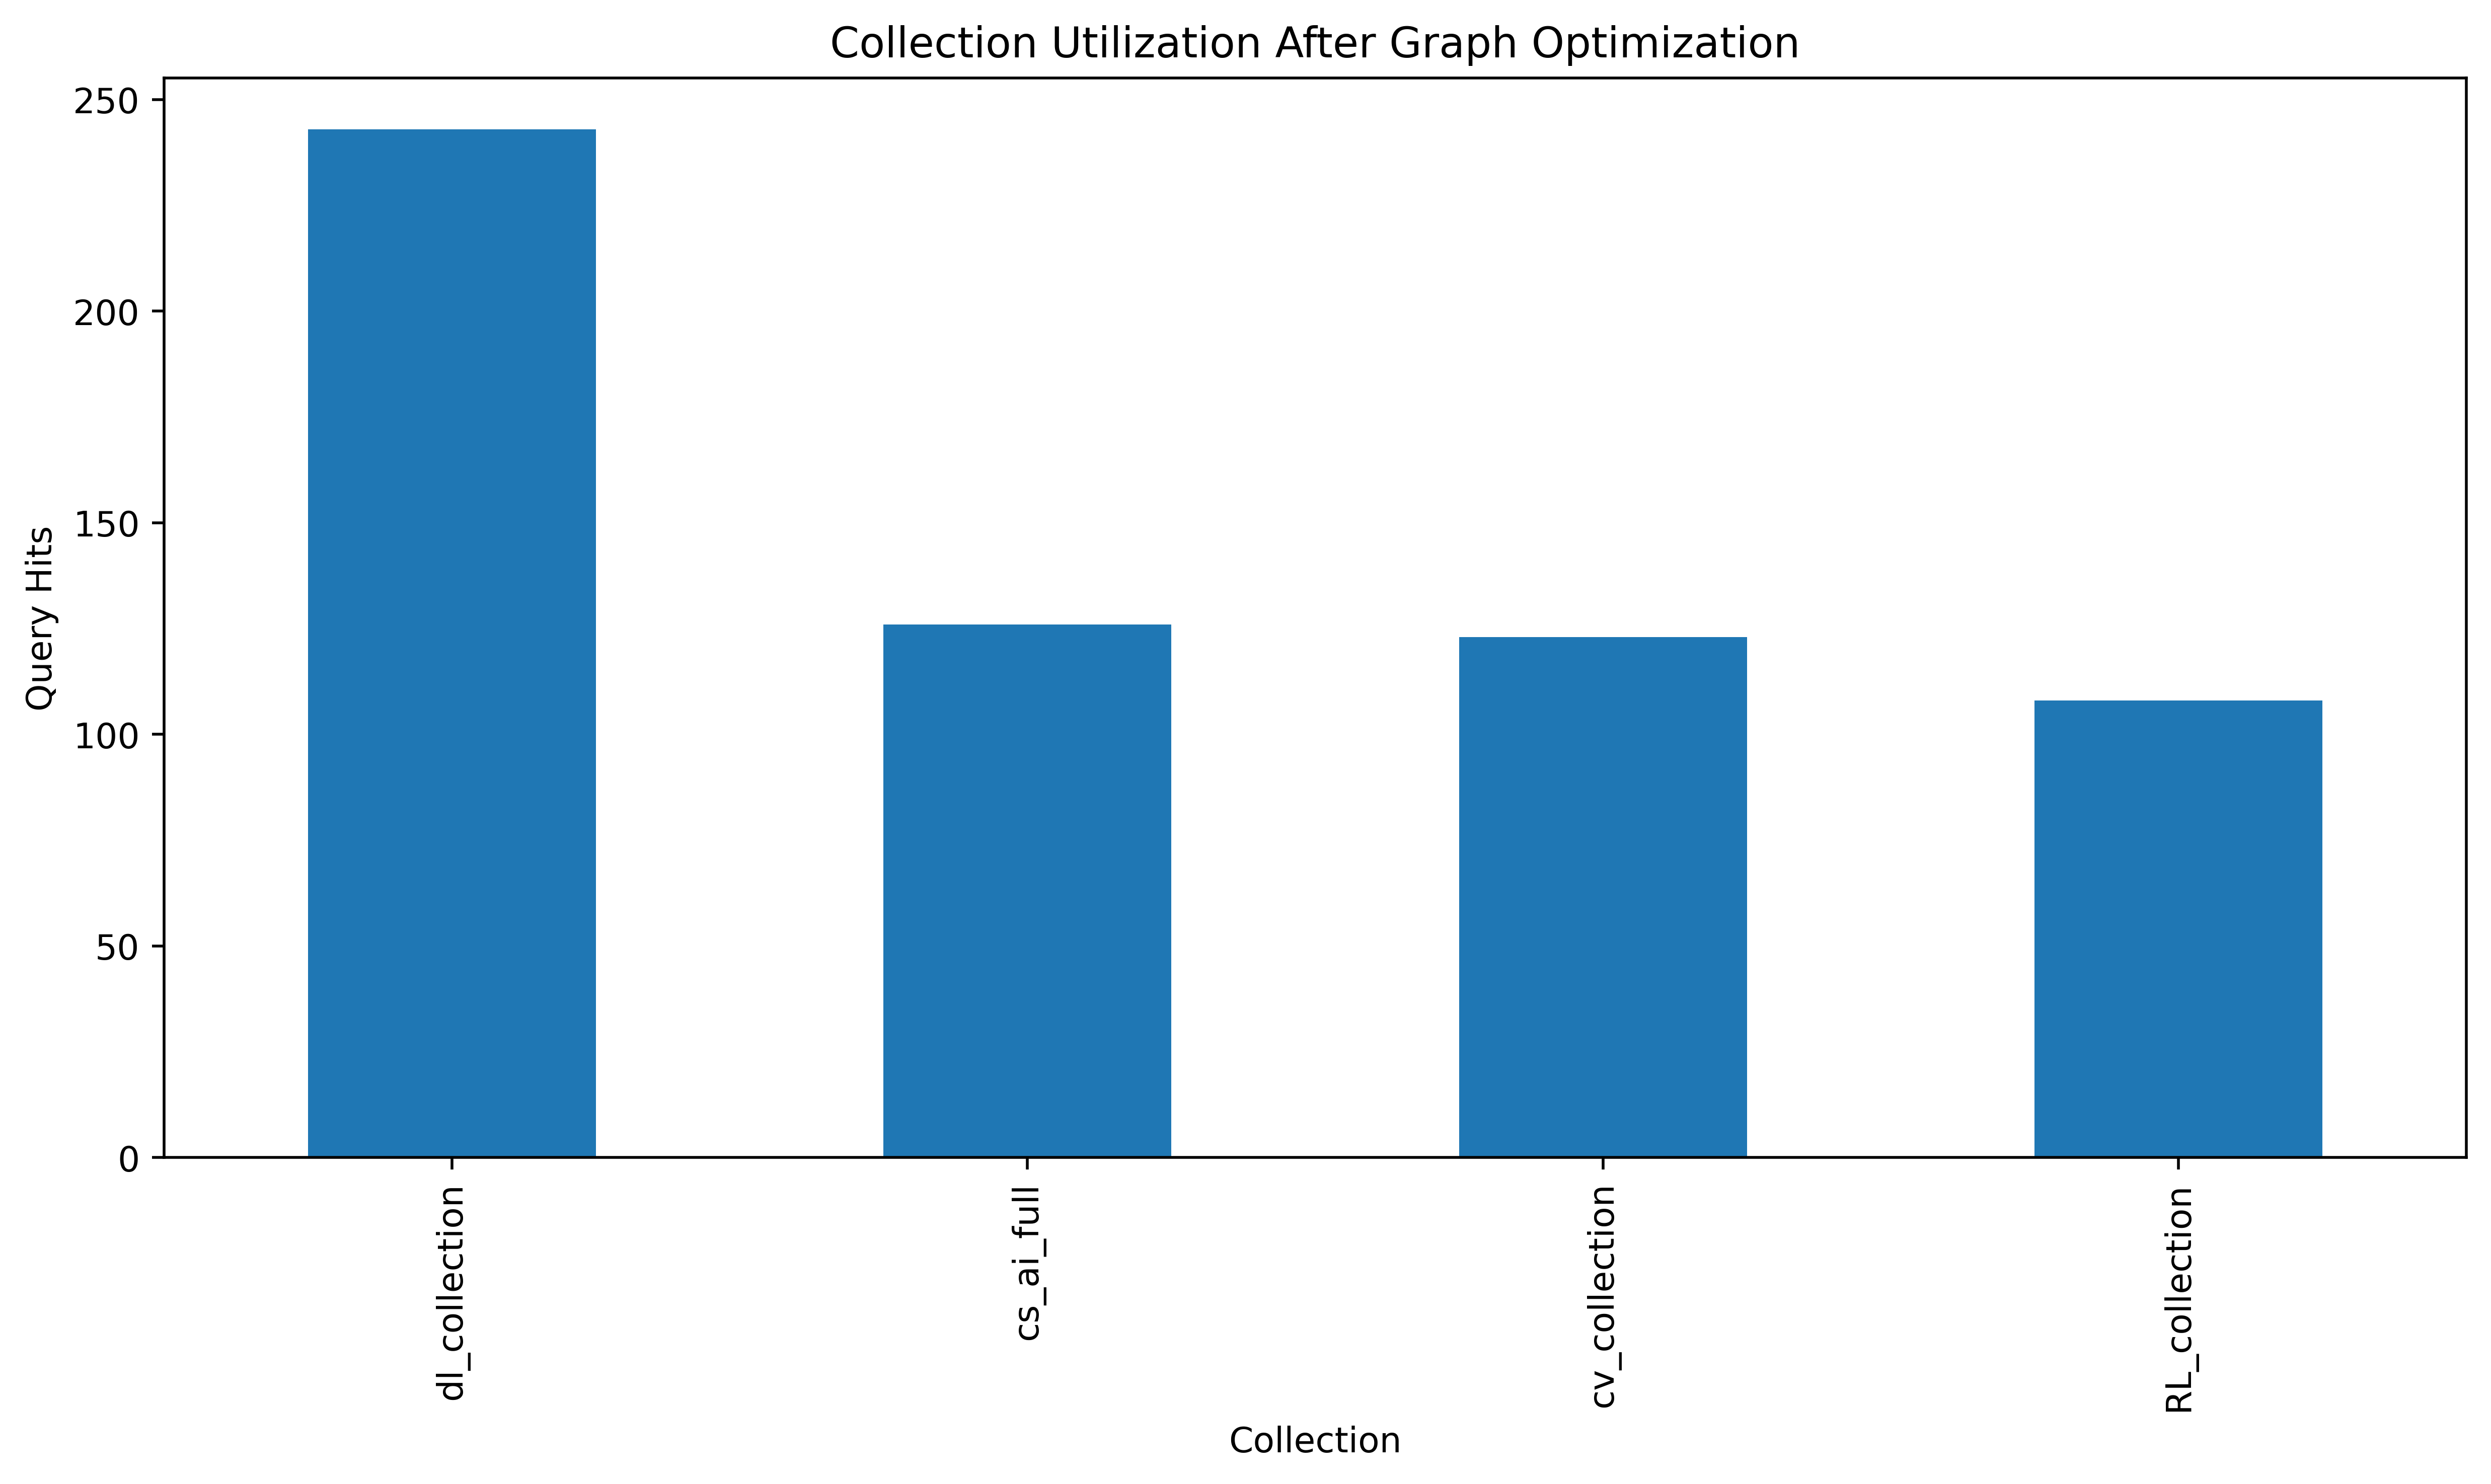

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6), dpi=500)
df["collection"].value_counts().plot(kind="bar")
plt.title("Collection Utilization After Graph Optimization")
plt.ylabel("Query Hits")
plt.xlabel("Collection")
plt.tight_layout()
plt.show()


### 8. Plot Relevance vs. Impact
Scatter plot of Similarity Score vs. Citation Count. High relevance (score) and high impact (citations) are desirable.

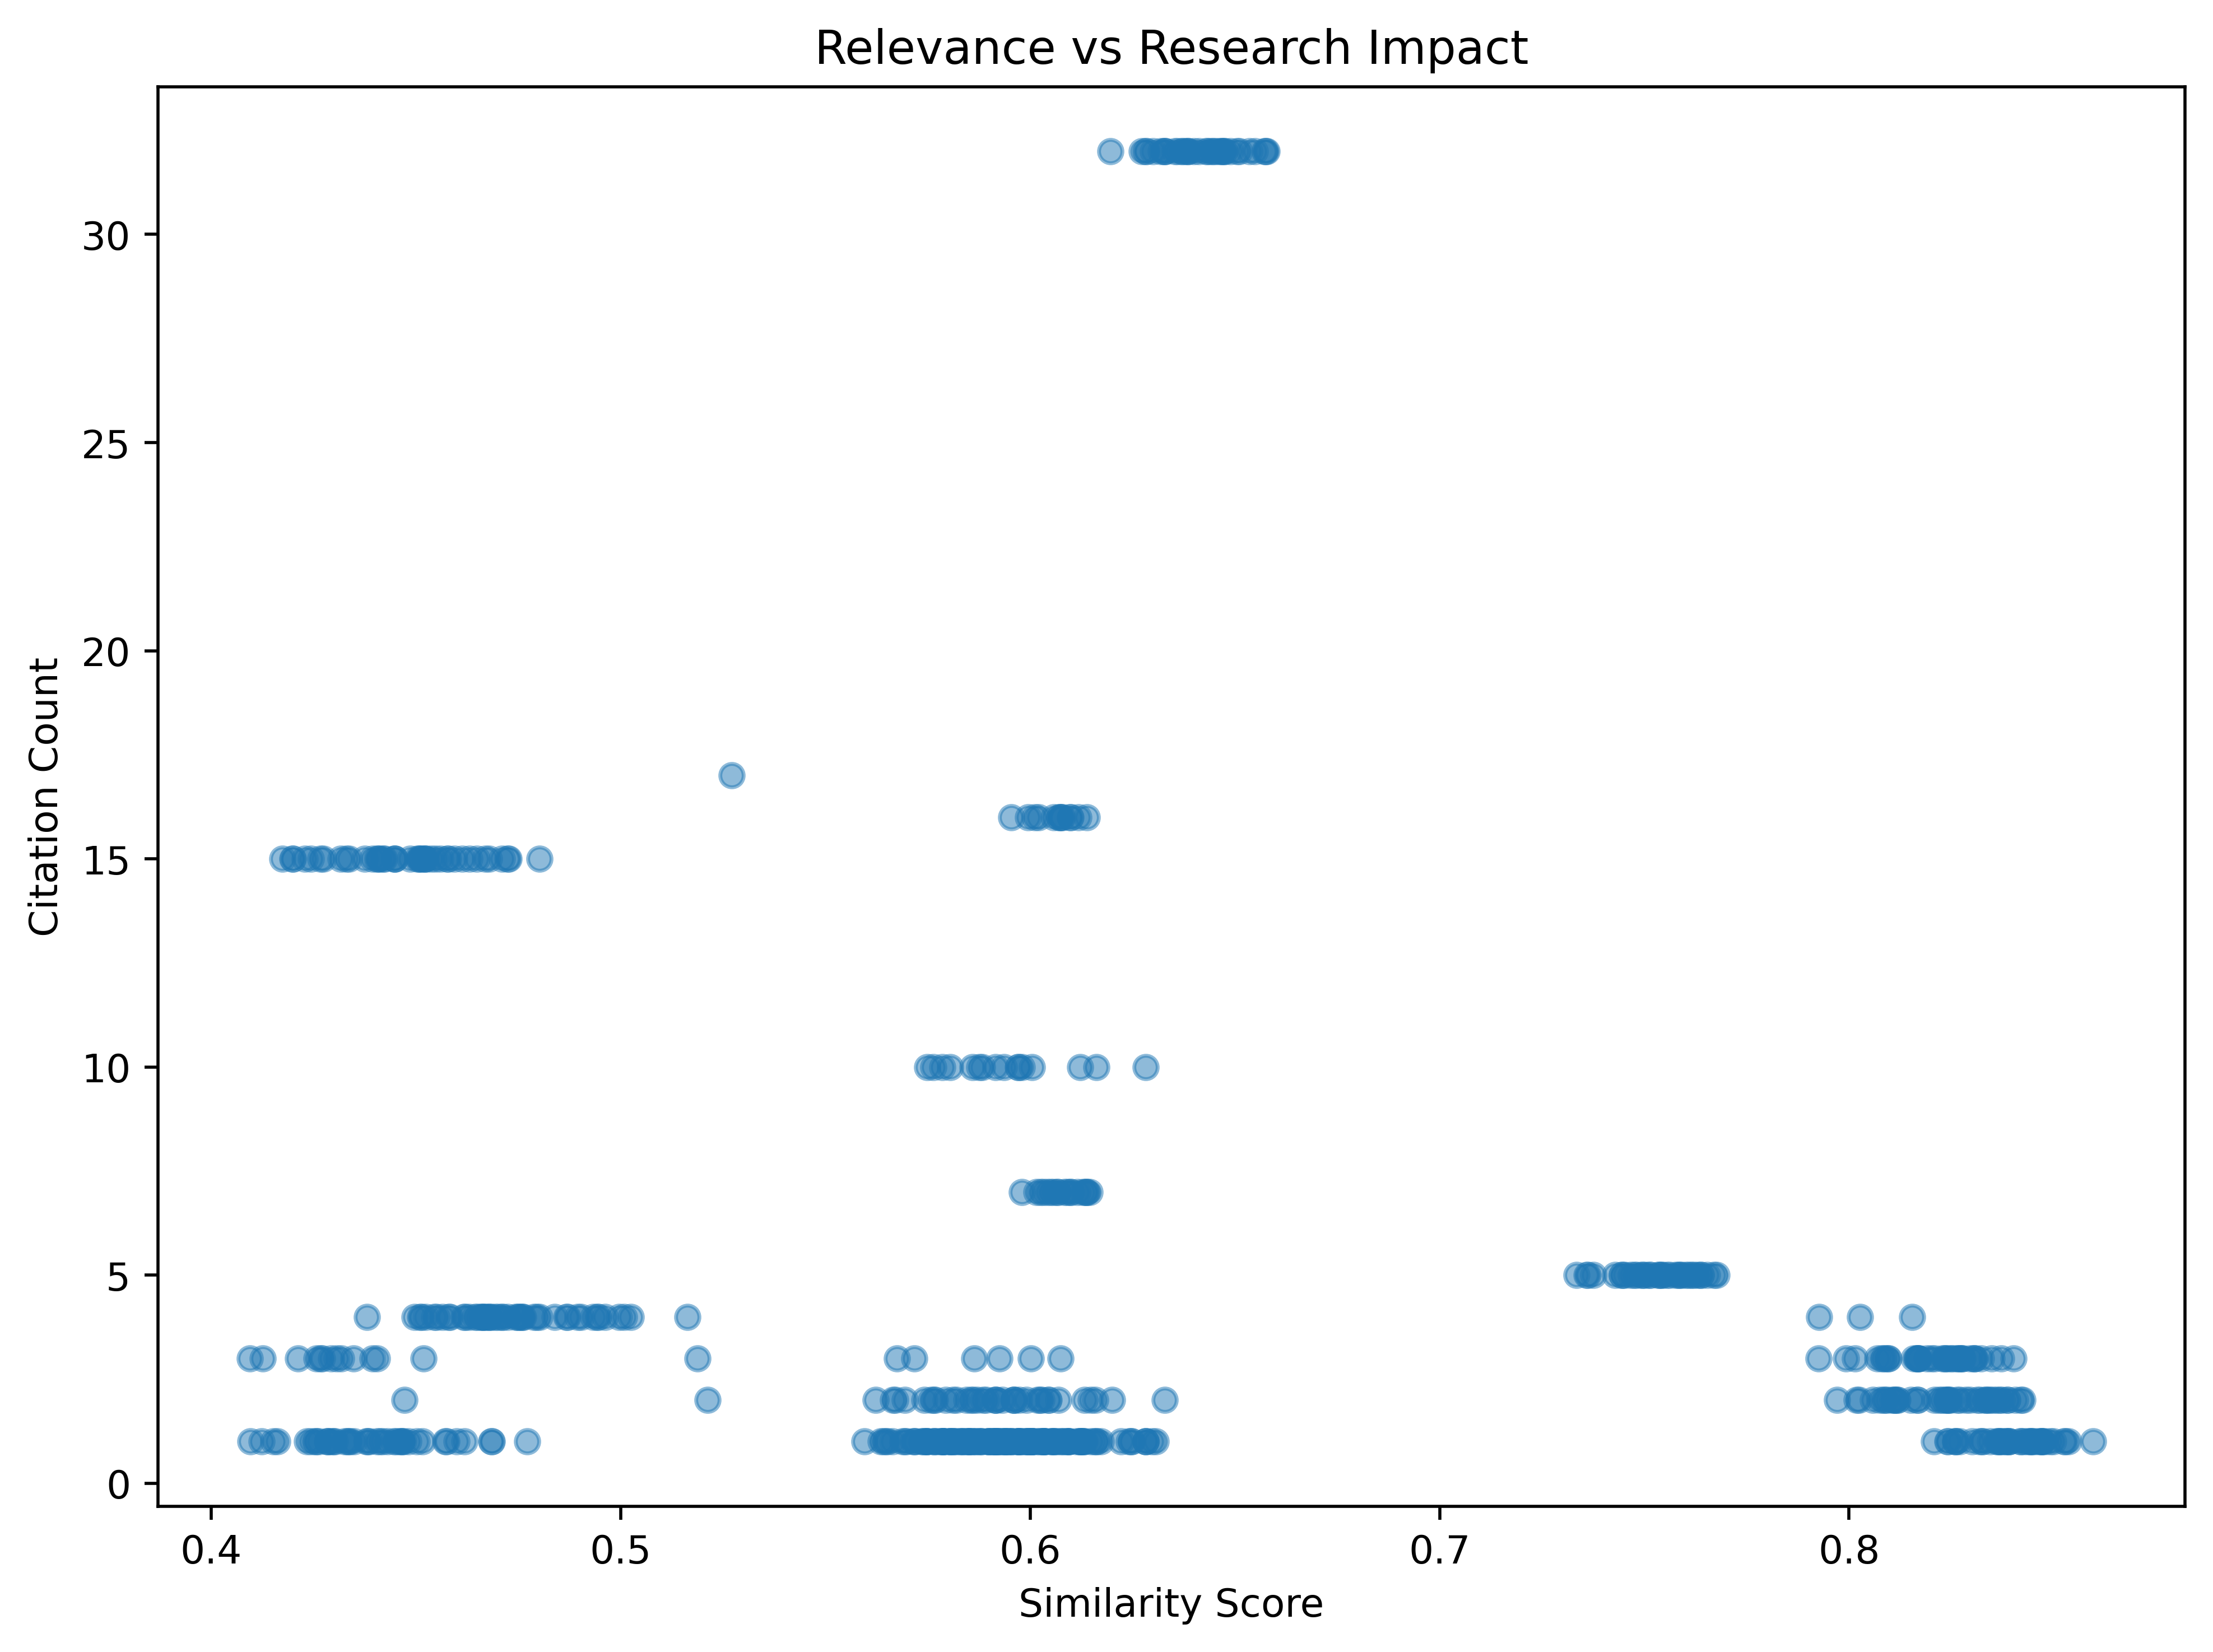

In [8]:
plt.figure(figsize=(8,6), dpi=500)
plt.scatter(df["score"], df["citations"], alpha=0.5)
plt.xlabel("Similarity Score")
plt.ylabel("Citation Count")
plt.title("Relevance vs Research Impact")
plt.tight_layout()
plt.show()


### 9. Plot Latency Distribution
Histogram of query latency. This confirms if the system meets the low-latency requirement (typically < 1s).

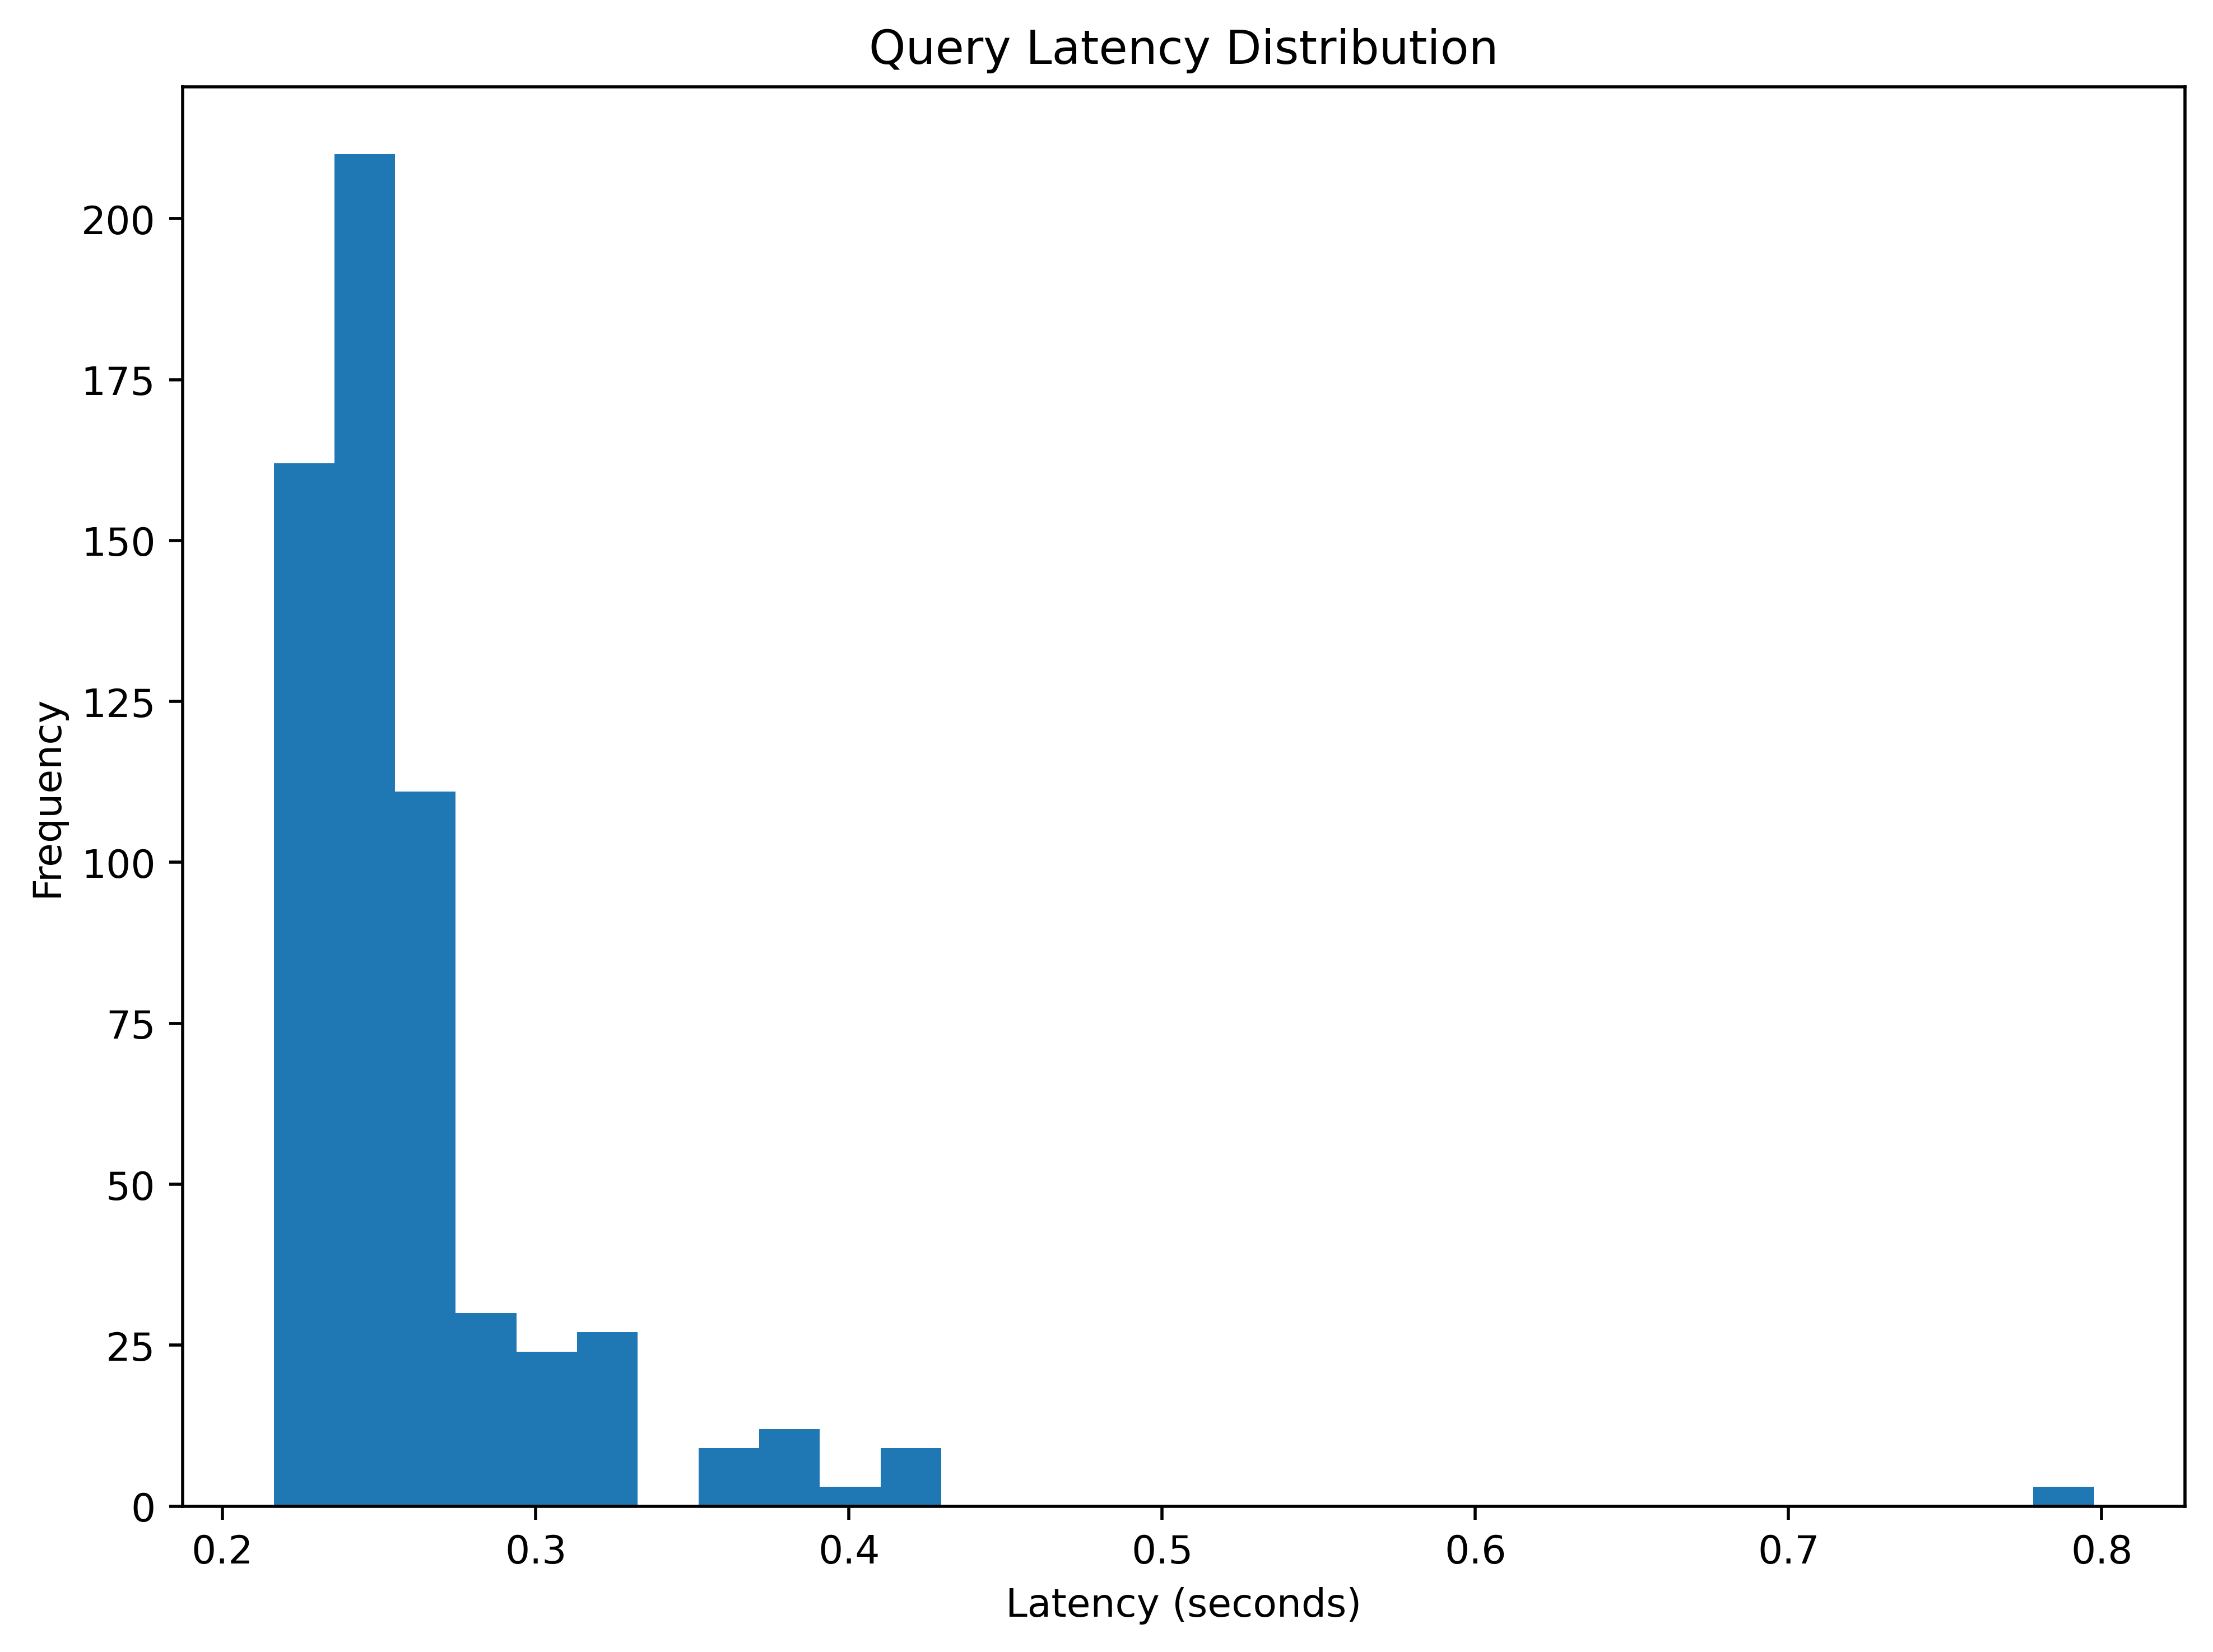

In [9]:
plt.figure(figsize=(8,6), dpi=500)
plt.hist(df["latency"], bins=30)
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Query Latency Distribution")
plt.tight_layout()
plt.show()
